In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
plt.style.use('dark_background')


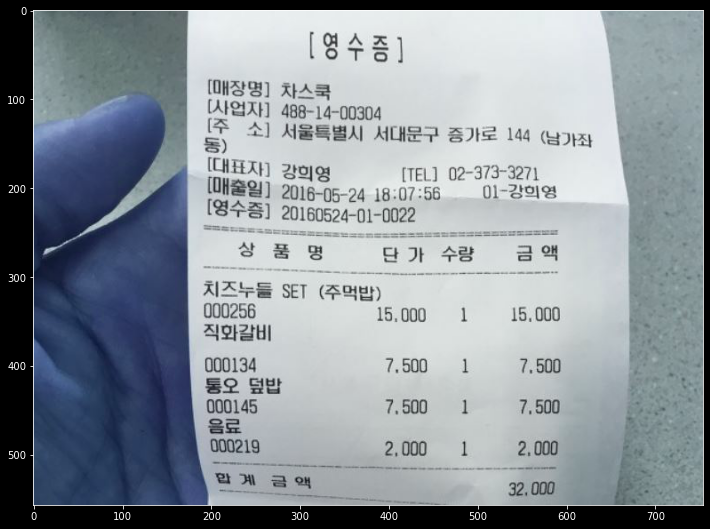

In [23]:
img_ori = cv2.imread(r'C:\Users\multicampus\Desktop\s03p23d202\textdetection\hander.jpg')
height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

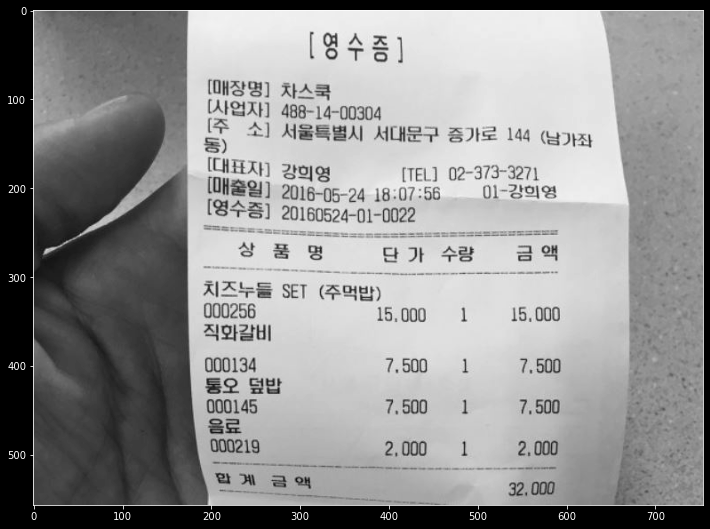

In [24]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

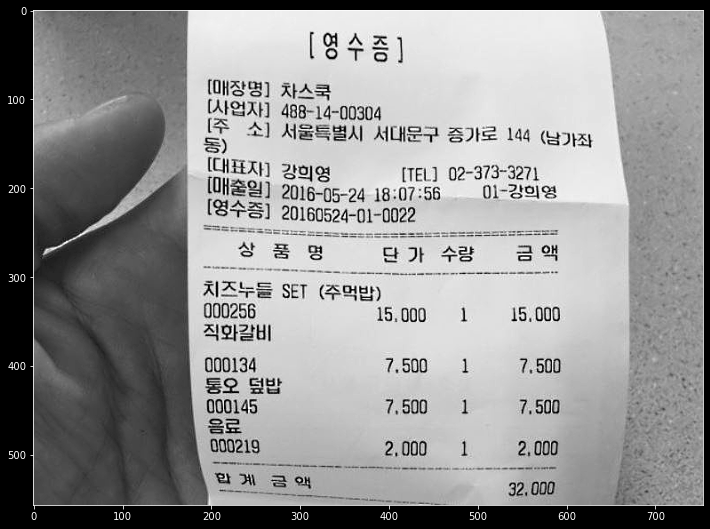

In [25]:

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

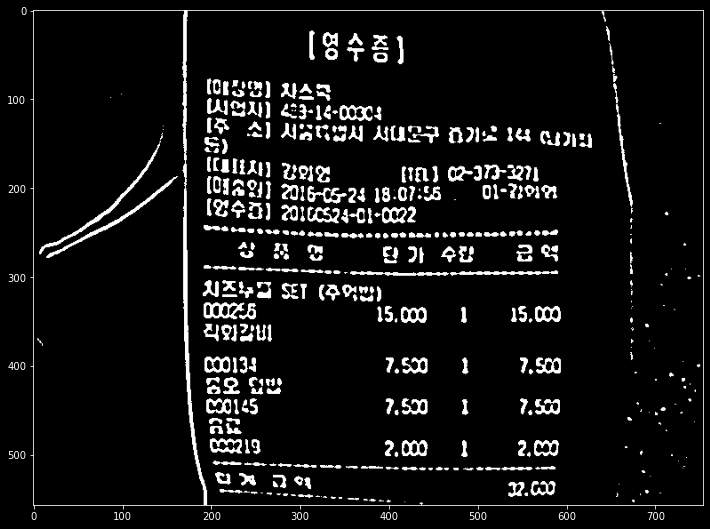

In [48]:
img_blurred = cv2.GaussianBlur(gray, ksize=(11, 11), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=11, 
    C=5
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

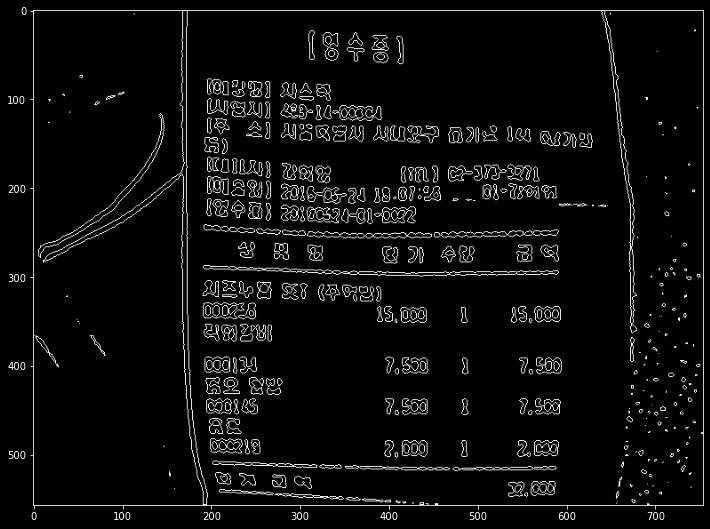

In [27]:
# _, contours, _ = cv2.findContours(
contours, hierarchy = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_TREE, 
    method=cv2.CHAIN_APPROX_SIMPLE
)
# print(test)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

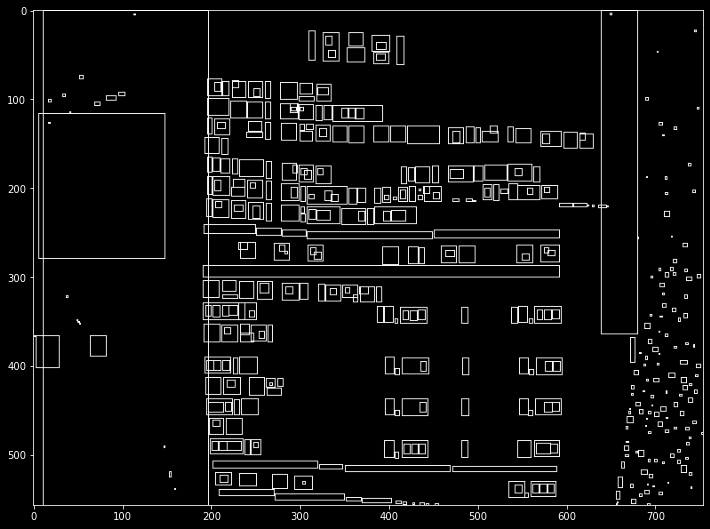

In [28]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=1)
#     print(x,y,w,h)
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

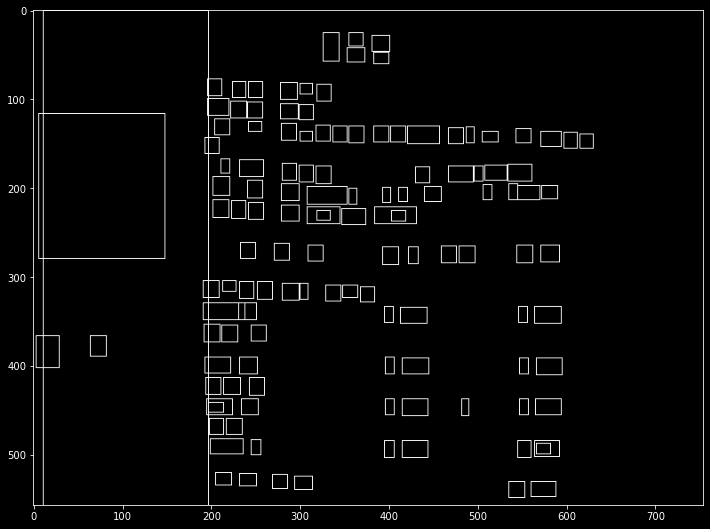

In [29]:
MIN_AREA = 150
MIN_WIDTH, MIN_HEIGHT = 5, 10
MIN_RATIO, MAX_RATIO = 0.25,3.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [30]:
# Select Candidates by Arrangement of Contours

# MAX_DIAG_MULTIPLYER = 20 # 5
# MAX_ANGLE_DIFF = 12.0 # 12.0
# MAX_AREA_DIFF = 0.5 # 0.5
# MAX_WIDTH_DIFF = 0.8
# MAX_HEIGHT_DIFF = 0.2
# MIN_N_MATCHED = 3 # 3

# def find_chars(contour_list):
#     matched_result_idx = []
    
#     for d1 in contour_list:
#         matched_contours_idx = []
#         for d2 in contour_list:
#             if d1['idx'] == d2['idx']:
#                 continue

#             dx = abs(d1['cx'] - d2['cx'])
#             dy = abs(d1['cy'] - d2['cy'])

#             diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

#             distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
#             if dx == 0:
#                 angle_diff = 90
#             else:
#                 angle_diff = np.degrees(np.arctan(dy / dx))
#             area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
#             width_diff = abs(d1['w'] - d2['w']) / d1['w']
#             height_diff = abs(d1['h'] - d2['h']) / d1['h']

#             if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
#             and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
#             and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
#                 matched_contours_idx.append(d2['idx'])

#         # append this contour
#         matched_contours_idx.append(d1['idx'])

#         if len(matched_contours_idx) < MIN_N_MATCHED:
#             continue

#         matched_result_idx.append(matched_contours_idx)

#         unmatched_contour_idx = []
#         for d4 in contour_list:
#             if d4['idx'] not in matched_contours_idx:
#                 unmatched_contour_idx.append(d4['idx'])

#         unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
#         # recursive
#         recursive_contour_list = find_chars(unmatched_contour)
        
#         for idx in recursive_contour_list:
#             matched_result_idx.append(idx)

#         break

#     return matched_result_idx
    
# result_idx = find_chars(possible_contours)

# matched_result = []
# for idx_list in result_idx:
#     matched_result.append(np.take(possible_contours, idx_list))

# # visualize possible contours
# temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# for r in matched_result:
#     for d in r:
# #         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
#         cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

# plt.figure(figsize=(12, 10))
# plt.imshow(temp_result, cmap='gray')

In [31]:
# Rotate Plate Images

# PLATE_WIDTH_PADDING = 1.3 # 1.3
# PLATE_HEIGHT_PADDING = 1.5 # 1.5
# MIN_PLATE_RATIO = 3
# MAX_PLATE_RATIO = 10

# plate_imgs = []
# plate_infos = []

# for i, matched_chars in enumerate(matched_result):
#     sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

#     plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
#     plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
#     plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
#     sum_height = 0
#     for d in sorted_chars:
#         sum_height += d['h']

#     plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
#     triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
#     triangle_hypotenus = np.linalg.norm(
#         np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
#         np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
#     )
    
#     angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
#     rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
#     img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
#     img_cropped = cv2.getRectSubPix(
#         img_rotated, 
#         patchSize=(int(plate_width), int(plate_height)), 
#         center=(int(plate_cx), int(plate_cy))
#     )
    
#     if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
#         continue
    
#     plate_imgs.append(img_cropped)
#     plate_infos.append({
#         'x': int(plate_cx - plate_width / 2),
#         'y': int(plate_cy - plate_height / 2),
#         'w': int(plate_width),
#         'h': int(plate_height)
#     })
    
#     plt.subplot(len(matched_result), 1, i+1)
#     plt.imshow(img_cropped, cmap='gray')

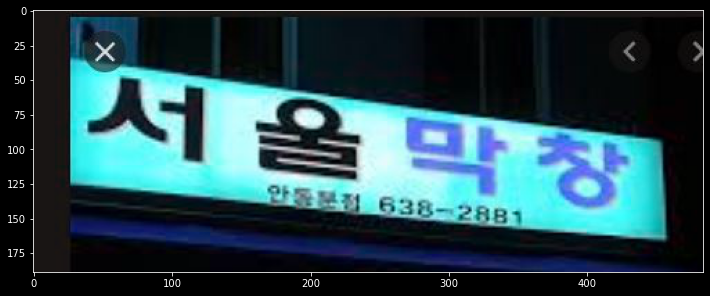

In [32]:
img_ori = cv2.imread(r'C:\Users\multicampus\Desktop\s03p23d202\textdetection\seoul2.jpg')
height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

245 483 11 17


ValueError: zero-size array to reduction operation minimum which has no identity

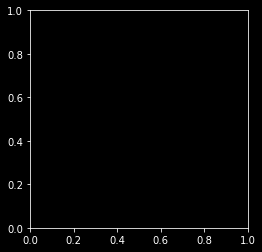

In [33]:
d = possible_contours[11]
print(d["x"], d["y"], d["w"], d["h"])
img_result = img_ori[d["y"]:(d["y"]+d["h"]), d["x"]:(d["x"]+d["w"])]
# plt.subplot(img_result)
plt.imshow(img_result)
# 160 64 78 59


In [ ]:
d1 = possible_contours[11]
d2 = possible_contours[10]
print(d["x"], d["y"], d["w"], d["h"])

if d1["x"] > d2["x"]:
    d1, d2 = d2, d1
    
img_result1 = img_ori[d1["y"]:(d1["y"]+d1["h"]), d1["x"]:(d1["x"]+d1["w"])]
plt.imshow(img_result1)




[245, 256] [483, 500]


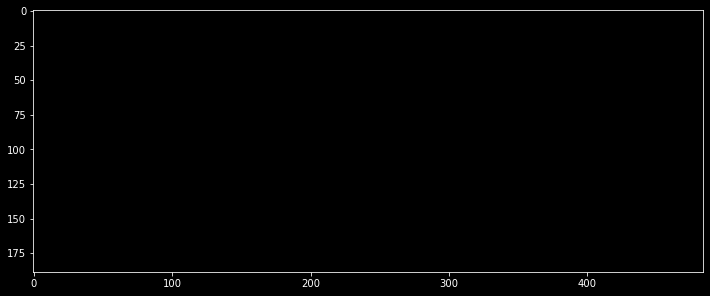

In [34]:
# make channel to 1 for making it binary
temp_result = np.zeros((height, width), dtype=np.uint8)

# put all boexs' coordinates info
all_x_coords = []
all_y_coords = []
# candidates list
candidates = set()

d = possible_contours[11]
cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color= 255 , thickness=-1)

all_x_coords.extend([d['x'],(d['x']+d['w'])])
all_y_coords.extend([d['y'], (d['y']+d['h'])])
print(all_x_coords,all_y_coords)

d1 = temp_result
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

[245, 256, 395, 406] [483, 500, 484, 503]


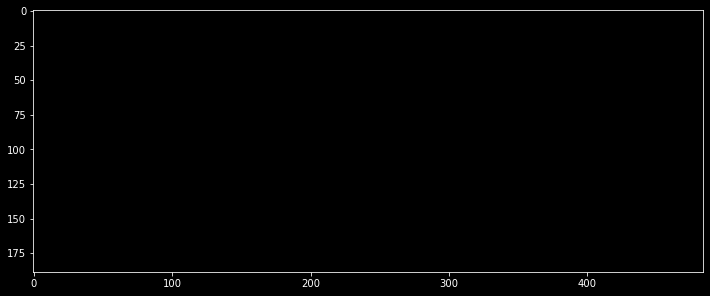

In [35]:
# make channel to 1 for making it binary
temp_result = np.zeros((height, width), dtype=np.uint8)

d = possible_contours[10]
cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color= 255 , thickness=-1)

all_x_coords.extend([d['x'],(d['x']+d['w'])])
all_y_coords.extend([d['y'], (d['y']+d['h'])])
print(all_x_coords,all_y_coords)


d2 = temp_result
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

0


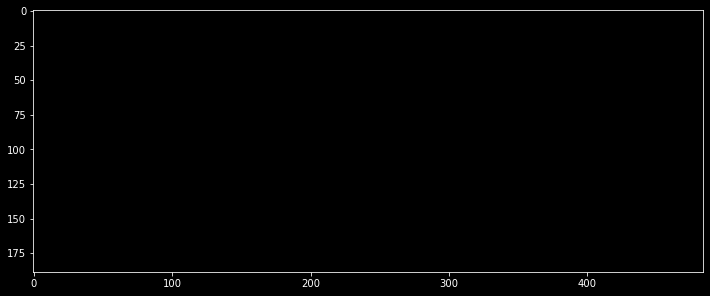

In [36]:
intersection = cv2.bitwise_and(d1, d2)

plt.figure(figsize=(12, 10))
plt.imshow(intersection, cmap='gray')

result = np.sum(intersection//255)
print(result)

In [37]:
if (result):
    #왼쪽 상단 : x젤 작은거, y젤 큰거
    left_top_coords = [min(all_x_coords),min(all_y_coords)]
    
    # 너비 : x젤 큰거 - x젤 작은거
    width = max(all_x_coords) - min(all_x_coords)
    
    # 높이 : y 젤 큰거 - y젤 작은거
    height = max(all_y_coords) - min(all_y_coords)
    
    print(left_top_coords, width, height)
    
    x = left_top_coords[0]
    y = left_top_coords[1]
    cv2.rectangle(temp_result, pt1=(x, y), pt2=((x+width), (y+height)), color= 255 , thickness=-1)

    d1 = temp_result
    
    candidates.add(d1)
    print(candidates)
    
    plt.figure(figsize=(12, 10))
    plt.imshow(temp_result, cmap='gray')

In [38]:
for cand in list(candidates) :
    plt.figure(figsize=(12, 10))
    plt.imshow(cand, cmap='gray')

In [39]:
# Another Thresholding to Find Chars

longest_idx, longest_text = -1, 0
plate_chars = []

plate_imgs = temp_result

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, hierarchy = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h
        print(area,ratio)
        
        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    chars = pytesseract.image_to_string(img_result, lang='kor+eng', config='--psm 7 --oem 0')
    print("chars : ",chars)
    
    result_chars = ''
#     has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣'):
            result_chars += c
#         if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
#             if c.isdigit():
#                 has_digit = True
#             result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

#     if has_digit and len(result_chars) > longest_text:
#         longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\core\src\matrix.cpp:757: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'cv::Mat::locateROI'


In [40]:
#result


info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)

NameError: name 'plate_infos' is not defined